In [1]:
import os
import sys
from pathlib import Path
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [2]:
import functools
import lzma
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numba as nb
import numpy as np
import pandas as pd
import pyteomics.mgf
import seaborn as sns
import tqdm.notebook as tqdm
from matplotlib.colors import LogNorm
import spectrum_utils.spectrum as sus
import similarity


In [33]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

## Setup parameters for the comparison


In [34]:
library_file = "../data/BILELIB19.mgf"
# library_file = "../data/20220418_ALL_GNPS_NO_PROPOGATED.mgf"

# analysis name
analysis_name = "bile_bib"

# square root transformation of intensities is often performed to limit the impact of high abundant signals
apply_sqrt = True

# size of subset of spectral pairs
n_spectral_pairs = 500000

# minimum number of signals only removes the spectra with less
min_n_signals = 6

# signal alignment tolerance
abs_mz_tolerance = 0.02
# only allow precursor mz difference of:
max_mz_delta = 200
# if defined, we will only search for specific delta m/z between two spectra
# 16 oxygen 15.994914
# otherwise define as -1
# specific_mod_mz = 15.9949
specific_mod_mz = -1

# analysis ID is used for file export
if specific_mod_mz <= 0:
    analysis_id = "{}_sqrt_{}_{}pairs_{}min_signals_{}maxdelta"\
        .format(analysis_name, apply_sqrt,n_spectral_pairs, min_n_signals, max_mz_delta).replace(".", "i")
else:
    analysis_id = "{}_sqrt_{}_{}pairs_{}min_signals_{}specific_delta"\
        .format(analysis_name, apply_sqrt,n_spectral_pairs, min_n_signals, specific_mod_mz).replace(".","i")

# output filename of pairs only with pair selection relevant parameters:
pairs_filename = "temp/{}_pairs.parquet".format(analysis_id).replace("sqrt_True_", "").replace("sqrt_False_", "")

In [35]:
# check for profile spectra in the library file - contains zero intensity values
def is_centroid(spectrum_dict):
    return all(i > 0 for i in spectrum_dict["intensity array"])

In [36]:
# Read all spectra from the ALL_GNPS.MGF from April 13. 2022
# library contains propagated spectra, that will be filtered out
# GNPS library from https://gnps-external.ucsd.edu/gnpslibrary
c_error = 0
c_propagated = 0
c_multi_charged = 0
c_removed = 0
c_profile_spec = 0
c_below_n_signals = 0
c_polarity = 0
c_not_protonated = 0
spectra = []
with pyteomics.mgf.MGF(library_file) as f_in:
    for spectrum_dict in tqdm.tqdm(f_in):
        # ignore:
        #   - propagated spectra with LIBRARYQUALITY==4
        #   - multiple charged molecules
        #   - < minimum signals
        #   - not positive mode
        #   - not M+H
        #   - not centroid (contains zero intensity values)
        try:
            if int(spectrum_dict["params"]["libraryquality"])>3:
                c_propagated += 1
            elif int(spectrum_dict["params"]["charge"][0])!=1:
                c_multi_charged +=1
            elif len(spectrum_dict["m/z array"])<min_n_signals:
                c_below_n_signals += 1
            elif str(spectrum_dict["params"]["ionmode"]) != "Positive":
                c_polarity += 1
            elif not str(spectrum_dict["params"]["name"]).rstrip().endswith(" M+H"):
                c_not_protonated += 1
            elif not is_centroid(spectrum_dict):
                c_profile_spec += 1
            else:
                intensities = spectrum_dict["intensity array"]
                if apply_sqrt:
                    intensities = np.sqrt(intensities)
                spectra.append(
                    sus.MsmsSpectrum(
                        spectrum_dict["params"]["spectrumid"],
                        float(spectrum_dict["params"]["pepmass"][0]),
                        int(spectrum_dict["params"]["charge"][0]),
                        spectrum_dict["m/z array"],
                        intensities,
                        #IONMODE=Positive
                        #LIBRARYQUALITY=4
                        #SPECTRUMID
                        # NAME
                        # SMILES
                    )
                )
        except:
            c_error += 1

c_removed = c_propagated + c_error + c_multi_charged + c_profile_spec + c_below_n_signals + c_polarity + c_not_protonated
print("total spectra={};  total removed={};  few signals={};  error={};  polarity mismatch={};  multi charge={};  propagated spec={};  not M+H={};  profile spec={}".format(len(spectra), c_removed, c_below_n_signals, c_error, c_polarity, c_multi_charged, c_propagated, c_not_protonated, c_profile_spec))

0it [00:00, ?it/s]

total spectra=846;  total removed=3687;  few signals=3;  error=0;  polarity mismatch=59;  multi charge=668;  propagated spec=0;  not M+H=2957;  profile spec=0


In [37]:
# sort spectra by precursor mz
spectra.sort(key=lambda spec: spec.precursor_mz)
# Extract precursor mz as filter argument
precursor_mz = nb.typed.List()
for spectrum in spectra:
    precursor_mz.append(spectrum.precursor_mz)

In [38]:
@nb.njit
def generate_pairs(precursor_mz):
    """
    Create pairs of spectra that are compared.
    Maximum precursor mz difference is 200 to limit the search space to a range from smaller modifications (e.g., +O) and
    larger modifications (e.g., hexose)

    Parameters
    ----------
    spectra a list of all spectra

    Returns yields two indices
    -------

    """
    for i in range(len(precursor_mz)):
        j = i + 1
        while (j < len(precursor_mz)) and (precursor_mz[j] <= precursor_mz[i] + max_mz_delta):
            delta = precursor_mz[j]-precursor_mz[i]
            if delta > 1:
                # list is sorted by precursor mz so j always > i
                # select only one specific precursor mz differance or include all
                if (specific_mod_mz < 0) or (abs(delta-specific_mod_mz) <= abs_mz_tolerance):
                    yield i
                    yield j
            j += 1

In [39]:
# try to load precomputed pairs
try:
    pairs_df= pd.read_parquet(pairs_filename)
except:
    # create pairs and randomly subset
    rng = np.random.default_rng(2022)
    pairs = np.fromiter(
        generate_pairs(precursor_mz),
        np.uint32).reshape((-1, 2))
    pairs = rng.choice(pairs, min(len(pairs), n_spectral_pairs), replace=False)

    pairs_df = pd.DataFrame(pairs, columns=['index1','index2'])
    # save pairs to speed up reanalysis
    Path("temp/").mkdir(parents=True, exist_ok=True)
    pairs_df.to_parquet(pairs_filename)

In [40]:
print ("Comparing {} pairs".format(len(pairs_df)))

Comparing 340637 pairs


In [41]:
# common columns
ids_a, ids_b, delta_mz = [],[],[]
# lists of SimilarityTuples
cosines, modified_cosines, neutral_losses = [], [], []
for i, j in tqdm.tqdm(zip(pairs_df["index1"], pairs_df["index2"])):
    # calculate scores and add to lists
    cos = similarity.cosine(spectra[i], spectra[j], abs_mz_tolerance)
    mod_cos = similarity.modified_cosine(spectra[i], spectra[j], abs_mz_tolerance)
    nl = similarity.neutral_loss(spectra[i], spectra[j], abs_mz_tolerance)
    if (nl.score > 0) and (cos.score > 0) and (mod_cos.score > 0):
        cosines.append(cos)
        modified_cosines.append(mod_cos)
        neutral_losses.append(nl)
        ids_a.append(spectra[i].identifier)
        ids_b.append(spectra[j].identifier)
        delta_mz.append(abs(spectra[i].precursor_mz - spectra[j].precursor_mz))

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [43]:
similarities = pd.DataFrame(
    {
        "id1": ids_a,
        "id2": ids_b,
        "delta_mz": delta_mz
    }
)

tmp = pd.DataFrame(cosines)
tmp = tmp.add_prefix('cos_')
similarities = similarities.join(tmp)

tmp = pd.DataFrame(modified_cosines)
tmp = tmp.add_prefix('mod_')
similarities = similarities.join(tmp)

tmp = pd.DataFrame(neutral_losses)
tmp = tmp.add_prefix('nl_')
similarities = similarities.join(tmp)

len(similarities)

134394

In [44]:
Path("results/").mkdir(parents=True, exist_ok=True)
similarities.to_parquet("results/{}.parquet".format(analysis_id))
similarities.head(5)

,id1,id2,delta_mz,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,cos_matches,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,mod_matches,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p,nl_matches
0,CCMSLIB00006582626,CCMSLIB00006584710,32.041,0.253021,0.752308,0.020857,1,54,0.325500,0.863359,0.053959,2,59,0.173962,0.646030,0.053959,1,42
1,CCMSLIB00006584101,CCMSLIB00005464822,28.964,0.255197,0.643137,0.010397,0,316,0.288207,0.706052,0.010397,0,380,0.065977,0.350460,0.007317,0,199
2,CCMSLIB00006582415,CCMSLIB00006584162,108.021,0.474219,0.841953,0.059818,3,111,0.766874,0.982028,0.124362,5,135,0.307498,0.509573,0.124362,2,62
3,CCMSLIB00006582186,CCMSLIB00006583507,30.011,0.401008,0.902709,0.020735,1,84,0.460588,0.929210,0.054595,2,88,0.267475,0.794295,0.054595,1,74
4,CCMSLIB00006583524,CCMSLIB00006582801,39.011,0.326879,0.940513,0.038459,1,101,0.698876,0.985921,0.172665,6,107,0.481705,0.869186,0.172665,5,83


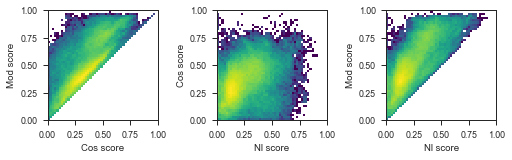

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(7.2, 7.2 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])
for i, (xlabel, ylabel) in enumerate(
        [
            ["cos_score", "mod_score"],
            ["nl_score", "cos_score"],
            ["nl_score", "mod_score"]
        ]
    ):
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axes[i],
        norm=LogNorm(),
    )
    axes[i].yaxis.set_major_locator(tick_locators)
    axes[i].set_yticklabels(tick_labels[::-1])
    axes[i].xaxis.set_major_locator(tick_locators)
    axes[i].set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    axes[i].set_xlabel(xlabel.replace("_", " ").capitalize())
    axes[i].set_ylabel(ylabel.replace("_", " ").capitalize())
    
plt.tight_layout()

Path("results/img/").mkdir(parents=True, exist_ok=True)
plt.savefig("results/img/{}.png".format(analysis_name), dpi=300, bbox_inches="tight")
plt.show()
plt.close()